<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignments/blob/main/assignment_1/Assignment_1_Q7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

import wandb

# Functions

In [ ]:
def weights_initialization(num_neurons, initializer):
  """
  num_neurons = list of number of neurons at each layer starting from the input layer and ending at output layer
  initializer = 'random' or 'xavier'

  Returns: initialized weight matrices and bias vectors
  """
  mean=0
  std_dev=1

  W_matrices = []
  b_vectors = []

  for i in range(len(num_neurons)-1):
    rows = num_neurons[i+1]
    cols = num_neurons[i]

    if initializer == 'random':

      weight_matrix = np.random.normal(mean, std_dev, size=(rows, cols))

    elif initializer == 'Xavier':

      upper_bound = np.sqrt(6.0/(rows + cols))
      lower_bound = -1*upper_bound
      weight_matrix = np.random.uniform(low = lower_bound, high = upper_bound, size = (rows, cols))

    else:
      print('initializer invalid')


    bias_vector = np.zeros((rows,1))

    W_matrices.append(weight_matrix)
    b_vectors.append(bias_vector)


  return W_matrices, b_vectors

################################################################################

# ACTIVATION FUNCTIONS
def relu(x):
  """
  Rectified Linear Unit (ReLU) activation function
  """
  return np.maximum(0, x)

def sigmoid(x):
  """
  Sigmoid activation function
  """
  # x = np.float128(x)
  return 1 / (1 + np.exp(-x))

def tanh(x):
  """
  Hyperbolic tangent (tanh) activation function
  """
  # x = np.float128(x)
  return np.tanh(x)
def softmax(x):

  """
  Softmax function for output layer
  """
  # x = np.float128(x)
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def activation_output(x, activation_function):
  """
  activation_function = 'ReLU', 'sigmoid', 'tanh'
  """
  if activation_function == 'ReLU':
    return relu(x)
  elif activation_function == 'sigmoid':
    return sigmoid(x)
  elif activation_function == 'tanh':
    return tanh(x)
  elif activation_function == 'softmax':
    return softmax(x)
  else:
    print('activation function invalid')

# DERIVATIVE OF ACTIVATION FUNCTION
def sigmoid_derivative(x):
  s = sigmoid(x)
  return s * (1 - s)

def tanh_derivative(x):
  t = tanh(x)
  return 1 - t**2

def relu_derivative(x):
  return 1*(x>0)

def activation_derivative(x, activation_function):
  """
  activation_function = 'ReLU', 'sigmoid', 'tanh'
  """
  if activation_function == 'ReLU':
    return relu_derivative(x)
  elif activation_function == 'sigmoid':
    return sigmoid_derivative(x)
  elif activation_function == 'tanh':
    return tanh_derivative(x)
  else:
    print('activation function invalid')

################################################################################

def layer_output_FP(x, weight_matrix, bias_vector, activation_function):
  pre_activation = np.add(np.matmul(weight_matrix, x), bias_vector)
  post_activation = activation_output(pre_activation, activation_function)
  return pre_activation, post_activation

def forward_propagation(ip_data, W_matrices, b_vectors, activation_functions):
  """
  forward propagation
  """

  layer_op = []
  layer_op.append(ip_data)

  layer_ip = []

  for i in range(len(W_matrices)):

    weight_matrix = W_matrices[i]
    bias_vector = b_vectors[i]

    activation_function = activation_functions[i]

    pre_activation, post_activation = layer_output_FP(layer_op[i], weight_matrix, bias_vector, activation_function)

    layer_op.append(post_activation)
    layer_ip.append(pre_activation)

  return layer_ip, layer_op

################################################################################

def back_propagation(W_matrices, b_vectors, y_true, layer_ip, layer_op, activation_functions, batch_size, w_d):

  DWs = []
  Dbs = []
  for i in range(len(W_matrices)):
    k = len(W_matrices) - i

    if k == len(W_matrices):
      Da = -np.add(y_true, -layer_op[k])
      Dw = (np.matmul(Da, layer_op[k-1].T) + w_d*W_matrices[k-1])/batch_size
    else:

      Dh = np.matmul(W_matrices[k].T, Da)
      Dg = activation_derivative(layer_ip[k-1], activation_functions[k-1])
      Da = np.multiply(Dh, Dg)
      Dw = (np.matmul(Da, layer_op[k-1].T) + w_d*W_matrices[k-1])/batch_size
    Db = np.sum(Da, axis=1, keepdims=True)/batch_size

    DWs.append(Dw)
    Dbs.append(Db)

  return DWs, Dbs


################################################################################


def update_weights_gd(W_matrices, b_vectors, DWs, Dbs, learning_rate = 0.1):

  DWs.reverse()
  Dbs.reverse()

  for i in range(len(DWs)):

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]
  return W_matrices, b_vectors

def update_weights_momentum(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1, beta = 0.5):
  DWs.reverse()
  Dbs.reverse()
  u_w = u_past_w
  u_b = u_past_b
  for i in range(len(DWs)):

    u_w[i] = beta*u_past_w[i] + DWs[i]
    u_b[i] = beta*u_past_b[i] + Dbs[i]

    W_matrices[i] = W_matrices[i] - learning_rate*u_w[i]
    b_vectors[i] = b_vectors[i] - learning_rate*u_b[i]

  return W_matrices, b_vectors, u_w, u_b

def update_weights_adagrad(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1):
  DWs.reverse()
  Dbs.reverse()

  u_w = u_past_w
  u_b = u_past_b
  eps = 1e-8
  for i in range(len(DWs)):
    u_w[i] = u_past_w[i] + DWs[i]**2
    u_b[i] = u_past_b[i] + Dbs[i]**2

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]/(np.sqrt(u_w[i]) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]/(np.sqrt(u_b[i]) + eps)

  return W_matrices, b_vectors, u_w, u_b

def update_weights_rmsprop(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1, beta = 0.5):
  DWs.reverse()
  Dbs.reverse()

  u_w = u_past_w
  u_b = u_past_b
  eps = 1e-8
  for i in range(len(DWs)):
    u_w[i] = beta*u_past_w[i] + (1-beta)*DWs[i]**2
    u_b[i] = beta*u_past_b[i] + (1-beta)*Dbs[i]**2

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]/(np.sqrt(u_w[i]) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]/(np.sqrt(u_b[i]) + eps)

  return W_matrices, b_vectors, u_w, u_b

def update_weights_adam(W_matrices, b_vectors, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate = 0.1, beta1 = 0.5, beta2 =0.5):
  DWs.reverse()
  Dbs.reverse()
  mw = mw_past
  mb = mb_past
  vw = vw_past
  vb = vb_past
  eps = 1e-8

  for i in range(len(DWs)):
    mw[i] = beta1*mw_past[i] + (1-beta1)*DWs[i]
    mb[i] = beta1*mb_past[i] + (1-beta1)*Dbs[i]

    mw_cap = mw[i]/(1 - beta1**t)
    mb_cap = mb[i]/(1 - beta1**t)

    vw[i] = beta2*vw_past[i] + (1-beta2)*DWs[i]**2
    vb[i] = beta2*vb_past[i] + (1-beta2)*Dbs[i]**2
    vw_cap = vw[i]/(1 - beta2**t)
    vb_cap = vb[i]/(1 - beta2**t)

    W_matrices[i] = W_matrices[i] - learning_rate*mw_cap/(np.sqrt(vw_cap) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*mb_cap/(np.sqrt(vb_cap) + eps)

  return W_matrices, b_vectors, mw, mb, vw, vb

def update_weights_nadam(W_matrices, b_vectors, DWs, Dbs, mw_past, mb_past, vw_past, vb_past,t,  learning_rate = 0.1, beta1 = 0.5, beta2 =0.5):
  DWs.reverse()
  Dbs.reverse()
  mw = mw_past
  mb = mb_past
  vw = vw_past
  vb = vb_past
  eps = 1e-8

  for i in range(len(DWs)):
    mw[i] = beta1*mw_past[i] + (1-beta1)*DWs[i]
    mb[i] = beta1*mb_past[i] + (1-beta1)*Dbs[i]

    mw_cap = mw[i]/(1 - beta1**(t+1))
    mb_cap = mb[i]/(1 - beta1**(t+1))

    vw[i] = beta2*vw_past[i] + (1-beta2)*DWs[i]**2
    vb[i] = beta2*vb_past[i] + (1-beta2)*Dbs[i]**2
    vw_cap = vw[i]/(1 - beta2**(t+1))
    vb_cap = vb[i]/(1 - beta2**(t+1))

    W_matrices[i] = W_matrices[i] - learning_rate*(beta1*mw_cap + ((1-beta1)/(1 - beta1**(t+1)))*DWs[i])/(np.sqrt(vw_cap) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*(beta1*mb_cap + ((1-beta1)/(1 - beta1**(t+1)))*Dbs[i])/(np.sqrt(vb_cap) + eps)

  return W_matrices, b_vectors, mw, mb, vw, vb

def look_ahead_nag(W_s, b_s, u_past_w, u_past_b, beta = 0.5):
  for i in range(len(W_s)):
    W_s[i] = W_s[i] - beta*u_past_w[i]
    b_s[i] = b_s[i] - beta*u_past_b[i]
  return W_s, b_s

################################################################################


def one_hot_encode(integers, num_classes=None):
  if num_classes is None:
      num_classes = np.max(integers) + 1
  return np.eye(num_classes)[integers]

def cross_entropy_loss(y_true, y_pred, batch_size):
  # Clip the predicted probabilities to avoid numerical instability
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
  loss_value = np.sum(np.sum(y_true*np.log(y_pred), axis=0))/batch_size
  return loss_value*(-1)



def accuracy(y_true, y_pred, batch_size):
  n_correct = 0
  for i in range(0, batch_size, 1) :
    if y_true[:,i].argmax() == y_pred[:,i].argmax() :
      n_correct += 1
  return 100 * n_correct / batch_size

################################################################################

def load_split_dataset(test_ratio=0.3):
  # Load Fashion MNIST dataset
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  # Split the training set into training and validation sets
  X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=test_ratio, random_state=42)

  data_size = X_train.shape[0]
  X_train = (X_train.reshape(data_size, -1).T)/255
  Y_train = one_hot_encode(Y_train, 10).T

  data_size = X_val.shape[0]
  X_val = (X_val.reshape(data_size, -1).T)/255
  Y_val = one_hot_encode(Y_val, 10).T

  data_size = test_images.shape[0]
  X_test = (test_images.reshape(data_size, -1).T)/255
  Y_test = one_hot_encode(test_labels, 10).T

  return X_train, Y_train, X_val, Y_val, X_test, Y_test


# Train function

In [ ]:

def train_model(X_train,Y_train, X_test, Y_test, epoch=1,batch_size=25, num_neurons_hidden = [10], activation_functions = ['sigmoid'],
                weights_init_type='random', optimizer = 'sgd', learning_rate = 0.1, opti_beta = [0.5, 0.5], w_d = 0,  plot_acc_loss = False):

  """
  X has shape (number of features, number of samples in train data set)
  Y has shape (number of classes, number of samples in train data set)

  num_neurons_hidden = list of number of neurons at each hidden layer

  """
  num_ip_neurons = X_train.shape[0]
  num_op_neurons = Y_train.shape[0]
  num_neurons = [num_ip_neurons] + num_neurons_hidden + [num_op_neurons]
  activation_functions = activation_functions + ['softmax']

  W_s, b_s = weights_initialization(num_neurons, weights_init_type)
  print('Hyper parameters: \n')
  print("Weight initialization type : ", weights_init_type)
  print("Optimizer : ", optimizer)
  print("Learning rate (initial): ", learning_rate)
  print("Batch size: ", batch_size)
  print("-------------------")
  print("Architecture Description:\n")

  for i in range(len(num_neurons)-1):
    print("Layer: ", i+1, " ; number of neurons: ", num_neurons[i+1], " ; activation function: ", activation_functions[i])
    print("Weight matrix dimention", W_s[i].shape, "Bias vector dimention", b_s[i].shape)
    print("----------------")

  num_batches = np.floor(X_train.shape[1]/batch_size)
  print(num_batches)


  if optimizer == 'momentum':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'nag':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'rmsprop':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'adagrad':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'adam':
    mw_past = [x * 0 for x in W_s]
    mb_past = [x * 0 for x in b_s]
    vw_past = [x * 0 for x in W_s]
    vb_past = [x * 0 for x in b_s]
    t = 1

  elif optimizer == 'nadam':
    mw_past = [x * 0 for x in W_s]
    mb_past = [x * 0 for x in b_s]
    vw_past = [x * 0 for x in W_s]
    vb_past = [x * 0 for x in b_s]
    t = 1

  print('\n Start of training')

  ip_all, op_all = forward_propagation(X_train, W_s, b_s, activation_functions)
  loss_tr = cross_entropy_loss(Y_train, op_all[-1], X_train.shape[1])
  acc_tr = accuracy(Y_train, op_all[-1], Y_train.shape[1])

  ip_all, op_all = forward_propagation(X_test, W_s, b_s, activation_functions)
  loss_ts = cross_entropy_loss(Y_test, op_all[-1], X_test.shape[1])
  acc_ts = accuracy(Y_test, op_all[-1], Y_test.shape[1])

  print("Training Loss: ", loss_tr, "Training Accuracy: ", acc_tr, "Test Loss: ", loss_ts, "Testing Accuracy: ", acc_ts)


  train_loss = np.array([loss_tr])
  train_acc = np.array([acc_tr])

  val_loss = np.array([loss_ts])
  val_acc = np.array([acc_ts])

  for i in range(epoch):
    print('Epoch: ', i+1)

    for j in tqdm(range(int(num_batches))):
      batch_X = X_train[:,j*batch_size:(j+1)*batch_size]
      batch_Y = Y_train[:,j*batch_size:(j+1)*batch_size]


      if optimizer == 'sgd':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s = update_weights_gd(W_s, b_s, DWs, Dbs, learning_rate)

      elif optimizer == 'momentum':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_momentum(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])

      elif optimizer == 'adagrad':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_adagrad(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate)

      elif optimizer == 'rmsprop':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_rmsprop(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])

      elif optimizer == 'adam':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, mw_past, mb_past, vw_past, vb_past = update_weights_adam(W_s, b_s, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate, opti_beta[0], opti_beta[1])
        t =t +1

      elif optimizer == 'nadam':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, mw_past, mb_past, vw_past, vb_past = update_weights_nadam(W_s, b_s, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate, opti_beta[0], opti_beta[1])
        t =t +1
      elif optimizer == 'nag':
        PWs, Pbs = look_ahead_nag(W_s, b_s, u_past_w, u_past_b, opti_beta[0])
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(PWs, Pbs, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_momentum(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])


    ip_all, op_all = forward_propagation(X_train, W_s, b_s, activation_functions)
    loss_tr = cross_entropy_loss(Y_train, op_all[-1], X_train.shape[1])
    acc_tr = accuracy(Y_train, op_all[-1], Y_train.shape[1])

    ip_all, op_all = forward_propagation(X_test, W_s, b_s, activation_functions)
    loss_ts = cross_entropy_loss(Y_test, op_all[-1], X_test.shape[1])
    acc_ts = accuracy(Y_test, op_all[-1], Y_test.shape[1])

    print("Training Loss: ", loss_tr, "Training Accuracy: ", acc_tr, "Test Loss: ", loss_ts, "Testing Accuracy: ", acc_ts)

    train_loss = np.append(train_loss, [loss_tr])
    train_acc = np.append(train_acc, [acc_tr])

    val_loss = np.append(val_loss, [loss_ts])
    val_acc = np.append(val_acc, [acc_ts])

  if plot_acc_loss == True:

    fig, ax = plt.subplots()  # Create a figure and axes object
    ax.plot(np.arange(0, epoch + 1, 1), train_acc, color='r', label='training')
    ax.plot(np.arange(0, epoch + 1, 1), val_acc, color='g', label='validation')
    ax.set_title("Accuracy")  # Set title on the axes object
    ax.legend()
    plt.grid()
    plt.show()

    fig, ax = plt.subplots()  # Create a figure and axes object for the second plot
    ax.plot(np.arange(0, epoch + 1, 1), train_loss, color='r', label='training')
    ax.plot(np.arange(0, epoch + 1, 1), val_loss, color='g', label='validation')
    ax.set_title("Loss")  # Set title on the axes object
    ax.legend()
    plt.grid()
    plt.show()

  return W_s, b_s




In [ ]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split_dataset()

Hyper parameters: 

Weight initialization type :  Xavier
Optimizer :  adam
Learning rate (initial):  0.001
Batch size:  64
-------------------
Architecture Description:

Layer:  1  ; number of neurons:  128  ; activation function:  ReLU
Weight matrix dimention (128, 784) Bias vector dimention (128, 1)
----------------
Layer:  2  ; number of neurons:  128  ; activation function:  ReLU
Weight matrix dimention (128, 128) Bias vector dimention (128, 1)
----------------
Layer:  3  ; number of neurons:  128  ; activation function:  ReLU
Weight matrix dimention (128, 128) Bias vector dimention (128, 1)
----------------
Layer:  4  ; number of neurons:  10  ; activation function:  softmax
Weight matrix dimention (10, 128) Bias vector dimention (10, 1)
----------------
656.0

 Start of training
Training Loss:  2.380506853090515 Training Accuracy:  10.83095238095238 Test Loss:  2.380740535297584 Testing Accuracy:  10.927777777777777
Epoch:  1


100%|██████████| 656/656 [00:04<00:00, 138.25it/s]


Training Loss:  0.38231382181104134 Training Accuracy:  86.24761904761905 Test Loss:  0.3979436903583276 Testing Accuracy:  85.94444444444444
Epoch:  2


100%|██████████| 656/656 [00:03<00:00, 197.11it/s]


Training Loss:  0.3497486821789456 Training Accuracy:  87.64047619047619 Test Loss:  0.38340444900805537 Testing Accuracy:  86.97222222222223
Epoch:  3


100%|██████████| 656/656 [00:03<00:00, 169.98it/s]


Training Loss:  0.3468100429986813 Training Accuracy:  88.20238095238095 Test Loss:  0.3968403371329056 Testing Accuracy:  87.21666666666667
Epoch:  4


100%|██████████| 656/656 [00:08<00:00, 73.16it/s]


Training Loss:  0.3495456660667069 Training Accuracy:  88.21190476190476 Test Loss:  0.4186245449303616 Testing Accuracy:  87.01666666666667
Epoch:  5


100%|██████████| 656/656 [00:12<00:00, 54.31it/s]


Training Loss:  0.3428922566723735 Training Accuracy:  88.80714285714286 Test Loss:  0.4365408186759029 Testing Accuracy:  87.47222222222223
Epoch:  6


100%|██████████| 656/656 [00:12<00:00, 54.22it/s]


Training Loss:  0.34011590946095654 Training Accuracy:  88.97857142857143 Test Loss:  0.44181454075123305 Testing Accuracy:  87.55
Epoch:  7


100%|██████████| 656/656 [00:11<00:00, 55.11it/s]


Training Loss:  0.3465349717140528 Training Accuracy:  88.65238095238095 Test Loss:  0.4430730124055634 Testing Accuracy:  86.78888888888889
Epoch:  8


100%|██████████| 656/656 [00:12<00:00, 52.62it/s]


Training Loss:  0.3525522886908675 Training Accuracy:  88.97142857142858 Test Loss:  0.4718881928117876 Testing Accuracy:  87.35
Epoch:  9


100%|██████████| 656/656 [00:13<00:00, 47.55it/s]


Training Loss:  0.34847957031582816 Training Accuracy:  88.50238095238095 Test Loss:  0.4640889722003172 Testing Accuracy:  86.55555555555556
Epoch:  10


100%|██████████| 656/656 [00:15<00:00, 43.49it/s]


Training Loss:  0.37438773383601576 Training Accuracy:  88.45714285714286 Test Loss:  0.5129977301806584 Testing Accuracy:  86.95


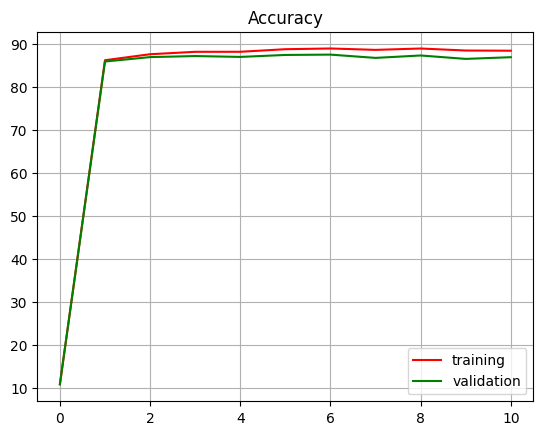

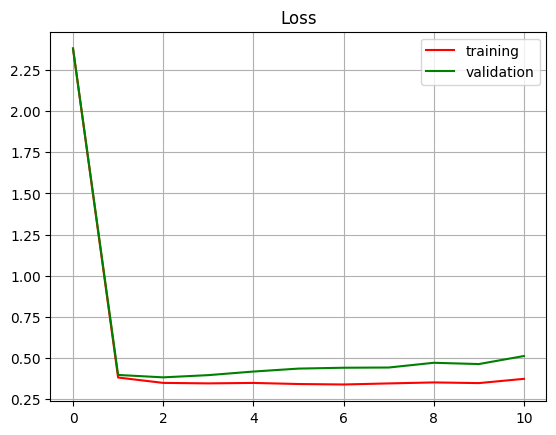

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

epochs = 10
nhl = 3
sz = 128
w_d = 0.0005
lr = 0.001
optimizer = 'adam'
b_sz = 64
weight_init = 'Xavier'
act_fun = 'ReLU'

neuros_num = []
act_func = []
for i in range(nhl):
  neuros_num.append(sz)
  act_func.append(act_fun)

W, b = train_model(X_train, Y_train, X_val, Y_val, epoch=epochs, batch_size=b_sz, num_neurons_hidden = neuros_num, activation_functions = act_func,
                weights_init_type=weight_init, optimizer = optimizer, learning_rate = lr, opti_beta = [0.5, 0.5], w_d = w_d, plot_acc_loss = True)

In [ ]:
activation_functions = act_func
activation_functions.append('softmax')

ip, op = forward_propagation(X_test, W, b, activation_functions)
Y_pred = op[-1]

Y_pred_int = []
Y_test_int = []
for i in range(Y_pred.shape[1]):
  Y_pred_int.append(Y_pred[:,i].argmax())
  Y_test_int.append(Y_test[:,i].argmax())

wandb.init(project='dl_assgn_1_q_7')

wandb.run.name = "Confusion_matrix_e_{}_hl_{}_hs_{}_lr_{}_opt_{}_bs_{}_init_{}_ac_{}_l2_{}".format(epochs, nhl, sz, lr, optimizer, b_sz, weight_init, act_fun, w_d)

wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        y_true=Y_test_int,
        preds=Y_pred_int,
        class_names=class_names
    )
})

# Finish the W&B run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arunangshudutta218 (arunangshudutta218-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
